In [1]:
# %matplotlib widget
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from matplotlib import cm
np.random.seed(42)

In [2]:
# User selection
K = 10
a, b = -1.1, 1.1
N_train = 80
N_test = 20
var = 0.5

In [3]:
theta_true = np.ones(K)
X_train = np.linspace(a, b, N_train)
X_test = np.random.uniform(a, b, N_test)
print("X_train shape :{}, X_test shape :{}".format(X_train.shape, X_test.shape))

X_train shape :(80,), X_test shape :(20,)


In [4]:
def generalized_vandermonde_matrix(func_list, X):
    K = len(func_list)
    N = len(X)
    matrix = np.zeros((N, K))
    for i, func in enumerate(func_list):
        matrix[:, i] = func(x=X)
    return matrix

def phi(j, x):
    return np.power(x, j)

def get_normal_vandermonde(K, X):
    vander = generalized_vandermonde_matrix(
        func_list=[partial(phi, j=j) for j in range(K)],
        X=X
    )
    return vander

In [5]:
def get_true_Y(K, X, theta_true, var):
    vander = get_normal_vandermonde(K, X)
    return vander @ theta_true + np.random.normal(0, np.sqrt(var), size=len(X))

Y_train = get_true_Y(K, X_train, theta_true, var)
Y_test = get_true_Y(K, X_test, theta_true, var)

print("Y_train shape :{}, Y_test shape :{}".format(Y_train.shape, Y_test.shape))

Y_train shape :(80,), Y_test shape :(20,)


In [6]:
def MLE_normal_equations(vander, Y):
    return np.linalg.inv(vander.T @ vander) @ vander.T @ Y

In [7]:
def loss(vander, Y, theta):
    N = len(Y)
    tmp = (vander @ theta) - Y
    return (tmp.T @ tmp)/N

In [8]:
def plot_results(k_range, SOL_func):

    _, axs = plt.subplots(1, 3, figsize=(15,3))

    axs = axs.flatten()

    x_plot = np.linspace(a, b, N_train*10)

    train_accuracy = []
    test_accuracy = []

    for k in k_range:
        vander_train = get_normal_vandermonde(k, X_train)
        theta_MLE = SOL_func(vander = vander_train, Y = Y_train)
        train_accuracy.append(loss(vander_train, Y_train, theta_MLE))

        vander_test = get_normal_vandermonde(k, X_test)
        test_accuracy.append(loss(vander_test, Y_test, theta_MLE))

        axs[2].plot(x_plot, get_normal_vandermonde(k, x_plot) @ theta_MLE, label="{}".format(k), alpha=0.7)


    axs[0].plot(k_range, train_accuracy, marker=".", label = "train")
    axs[0].plot(k_range, test_accuracy, marker=".", label = "test")
    axs[0].set_title("Loss")
    axs[0].set_ylabel("Loss")
    axs[0].set_xlabel("k")
    axs[0].legend()

    axs[1].plot(k_range, train_accuracy, marker=".", label = "train")
    axs[1].plot(k_range, test_accuracy, marker=".", label = "test")
    axs[1].legend()
    axs[1].set_title("Loss, y in log scale")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("k")
    axs[1].set_yscale("log")

    axs[2].vlines([a, b], axs[2].get_ylim()[0], axs[2].get_ylim()[1], colors="b", linestyles="dashed", alpha=0.2)
    axs[2].plot(X_train, Y_train, "+b", alpha=0.2, label="train data")
    axs[2].plot(X_test, Y_test, "+r", alpha=0.8, label="test data")
    axs[2].set_title("Regressors")
    axs[2].set_ylabel("y")
    axs[2].set_xlabel("x")
    axs[2].legend()

    plt.show()


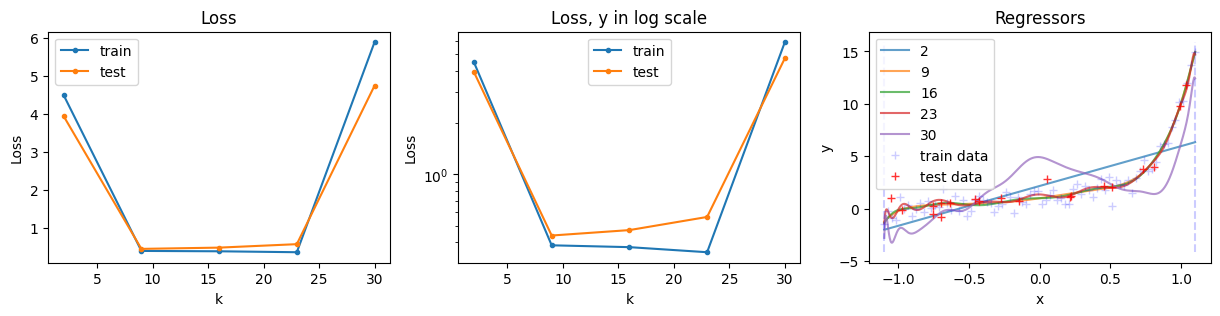

In [9]:
plot_results(range(2, 31, 7), MLE_normal_equations)


There are some problems with the fact that the polynomials diverge around the edge of the interval. This is normal for polynomial regression, because, expecially with higher powers of x, the terms explode quickly. Moreover, if, as in this case, the data split procedure caused one of the edge points to be in the test set, this would be completely missed by the higher degree polynomials and would cause a big test error.

However, it is indeed strange that the training error increases. This could be caused by the ill-conditioning of the vander matrix, which we saw in homework 1. 

Since the Normal Equations have solution $(\Phi^T \Phi)^{-1} \Phi^T \theta$, probably some numerical errors cause the more free and complex higher degree polynomial to miss training data, and the errors are exacerbated by the big powers of x (meaning that a small error causes a big loss).

So we try to restrict the polynomials to a lower maximum degree:

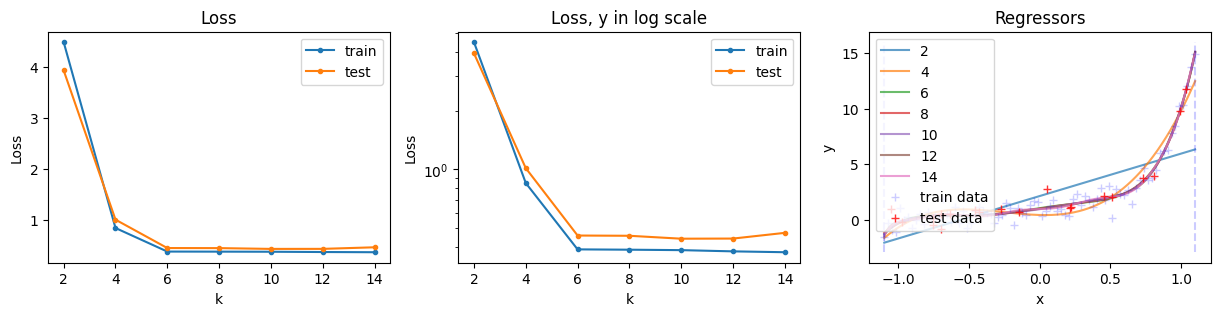

In [10]:
plot_results(range(2, 15, 2), MLE_normal_equations)


Lower values of k still have an enormous error are still very high because k=10 diverges quickly after 1 so the error on the extremes is high

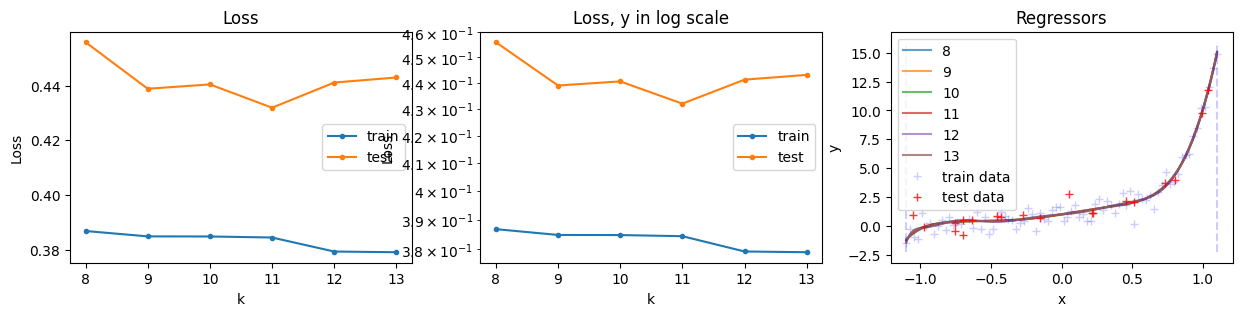

In [11]:
plot_results(range(8, 14), MLE_normal_equations)

Here we can see that more or less most of the regressors do a good job, but from k=12 we start seeing an overfitting trend, where the test loss is increasing while the train loss still decreases. So probably k ~ 11, not far from the real k=10.

## MAP

In [12]:
def MAP_normal_equations(vander, lmbd, Y):
    return np.linalg.inv(vander.T @ vander - lmbd * np.eye(vander.shape[1])) @ vander.T @ Y

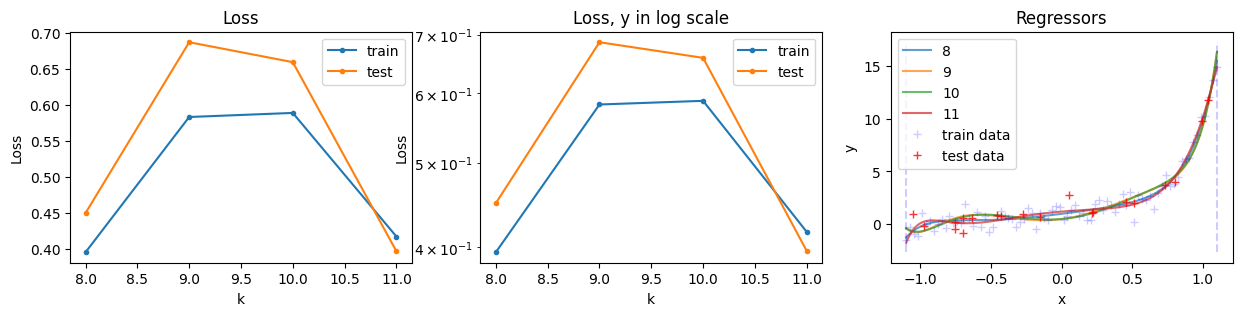

In [13]:
lmbd = 1e-1
plot_results(range(8, 12), partial(MAP_normal_equations, lmbd=lmbd))

In [14]:
def plot_results_varying_lmbd(k, SOL_func):
    
    _, axs = plt.subplots(1, 2, figsize=(15,3))
    axs = axs.flatten()

    x_plot = np.linspace(a, b, N_train*10)

    train_accuracy = []
    test_accuracy = []

    for lmbd in (lmbd_range := [0, 1e-3, 1e-2, 1e-1, 1]):
        vander_train = get_normal_vandermonde(k, X_train)
        theta_MLE = SOL_func(vander = vander_train, Y = Y_train, lmbd=lmbd)
        train_accuracy.append(loss(vander_train, Y_train, theta_MLE))

        vander_test = get_normal_vandermonde(k, X_test)
        test_accuracy.append(loss(vander_test, Y_test, theta_MLE))

        axs[1].plot(x_plot, get_normal_vandermonde(k, x_plot) @ theta_MLE, label="{}".format(lmbd), alpha=0.7)

    axs[0].plot([1e-4]+lmbd_range[1:], train_accuracy, marker=".", label = "train")
    axs[0].plot([1e-4]+lmbd_range[1:], test_accuracy, marker=".", label = "test")
    axs[0].set_title("Loss")
    axs[0].set_ylabel("Loss")
    axs[0].set_xlabel("lambda")
    axs[0].set_xscale("log")
    axs[0].set_xticks([1e-4]+lmbd_range[1:], ["MLE"]+[str(x) for x in lmbd_range[1:]])
    axs[0].legend()

    axs[1].vlines([a, b], axs[1].get_ylim()[0], axs[1].get_ylim()[1], colors="b", linestyles="dashed", alpha=0.2)
    axs[1].plot(X_train, Y_train, "+b", alpha=0.2, label="train data")
    axs[1].plot(X_test, Y_test, "+r", alpha=0.8, label="test data")
    axs[1].set_title("Regressors varying lambda, k = {}".format(k))
    axs[1].set_ylabel("y")
    axs[1].set_xlabel("x")
    axs[1].legend()

    plt.show()

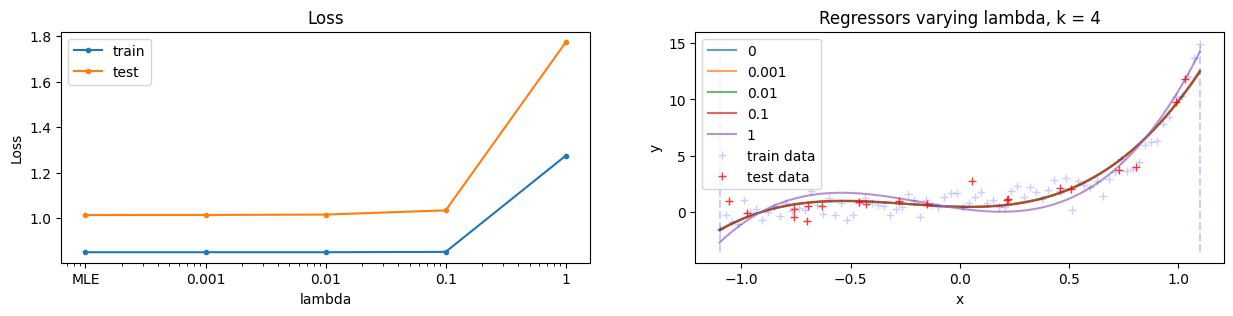

In [15]:
plot_results_varying_lmbd(4, MAP_normal_equations)

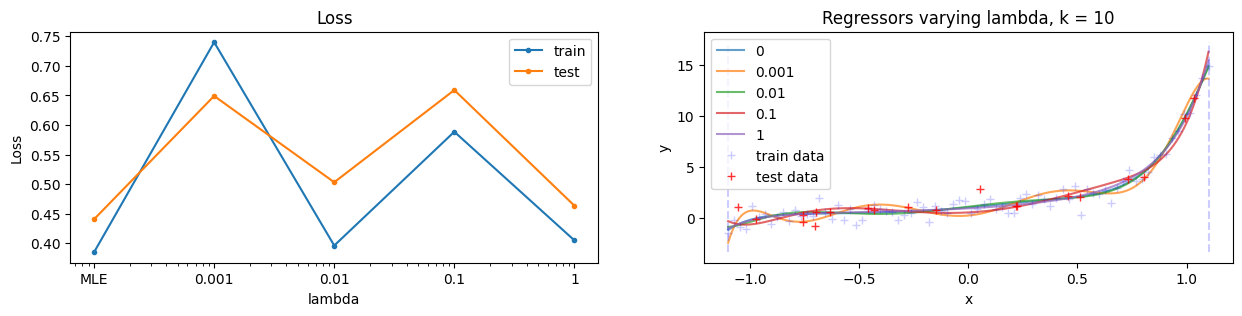

In [16]:
plot_results_varying_lmbd(10, MAP_normal_equations)

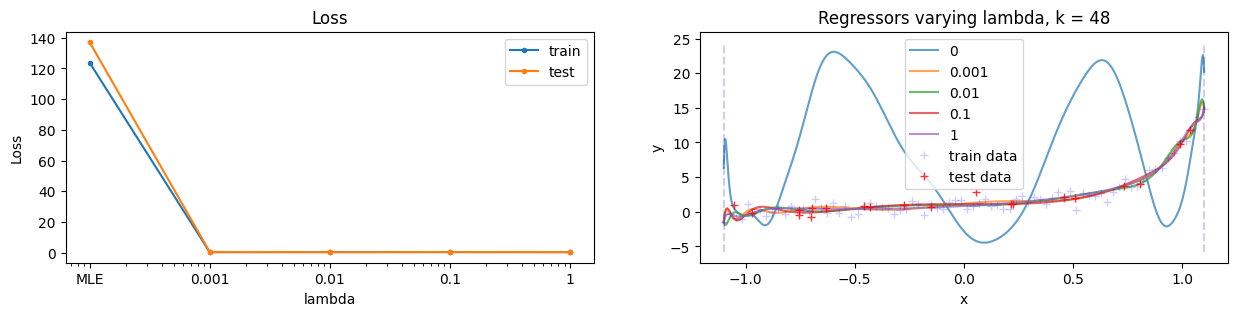

In [17]:
plot_results_varying_lmbd(48, MAP_normal_equations)

We can see that the the addition of a regularization (or the addition of the supposition on the prior distribution on the weights) has a big impact on the performance and the behavior of the regressor. In fact, while the lower capacity models are not really improved by the regularization, we can see that instead the "right capacity" or right degree regressor is affected in a variable way (because MLE, so $\lambda=0$) is actually the correct function.

The largest difference, however, can be seen if we look at regressors with much higher capacity than the correct degree: with MLE the ill-conditioning of the vandermonde matrix brings the predictions out of their way and the loss to very high values, but even with a very small regularization (1e-3) the new matrix is way better conditioned, its eigenvalues are brought up by lambda and its condition number lowers, and this allows for the model to be much more numerically stable and to be actually able to exploit the much higher capacity to better fit the data.

In [18]:
def param_error(k, lmbd, theta_true):
    vander_train = get_normal_vandermonde(k, X_train)
    theta_MLE = MAP_normal_equations(vander = vander_train, Y = Y_train, lmbd=lmbd)
    
    resized_th_true = np.pad(theta_true, (0, k-len(theta_true)))

    return np.linalg.norm(resized_th_true - theta_MLE) / np.linalg.norm(resized_th_true)

In [23]:
def plot_3d(k_vals, lmbd_ticks, lmbd_labels, lmbd_vals, ax, title="", rotation=40):

    X_2dplot, Y_2dplot = np.meshgrid(k_vals, lmbd_ticks)

    Z_2dplot = np.zeros((len(lmbd_vals), len(k_vals)))

    for i, k in enumerate(k_vals):
        for j, lmbd in enumerate(lmbd_vals):
            Z_2dplot[j, i] = param_error(k, lmbd, theta_true)

    surf = ax.plot_surface(X_2dplot, Y_2dplot, Z_2dplot, linewidth=0.5, cmap=cm.coolwarm, antialiased=False)
    ax.set_title(title)

    ax.set_xlabel("k")

    ax.set_ylabel("lambda (log scale)")
    ax.set_yticks(lmbd_ticks)
    ax.set_yticklabels(lmbd_labels)

    ax.set_zlabel("Relative error on theta")
    ax.set_zscale("log")
    ax.view_init(20, rotation)

    ax.invert_xaxis()

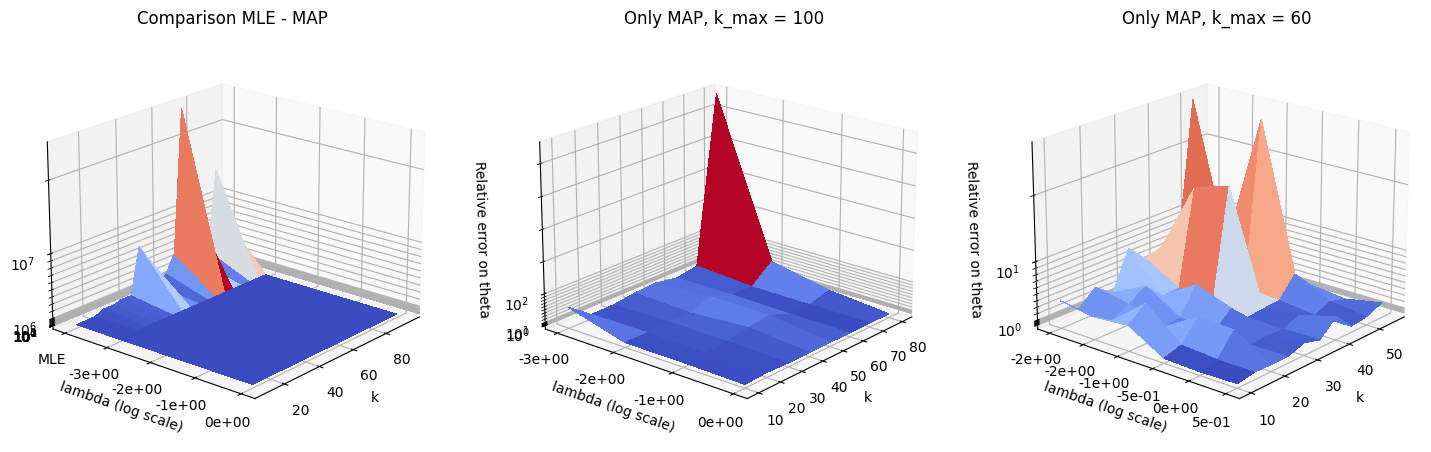

In [24]:
fig, axs = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(18, 8))
axs = axs.flatten()

k_vals      = np.arange(10, 100, 5)
lmbd_ticks = list(np.arange(-4, 1, 1))
lmbd_labels = ["MLE"]+["{:.0e}".format(x) for x in lmbd_ticks[1:]]
lmbd_vals = np.array([0]+list(np.power(10., lmbd_ticks[1:])))
plot_3d(k_vals, lmbd_ticks, lmbd_labels, lmbd_vals, axs[0], title="Comparison MLE - MAP")

k_vals      = np.arange(10, 90, 10)
lmbd_ticks = list(np.arange(-3, 1, 1))
lmbd_labels = ["{:.0e}".format(x) for x in lmbd_ticks]
lmbd_vals = np.power(10., lmbd_ticks)
plot_3d(k_vals, lmbd_ticks, lmbd_labels, lmbd_vals, axs[1], title="Only MAP, k_max = 100")

k_vals      = np.arange(10, 60, 5)
lmbd_ticks = list(np.arange(-2, 1, 0.5))
lmbd_labels = ["{:.0e}".format(x) for x in lmbd_ticks]
lmbd_vals = np.power(10., lmbd_ticks)
plot_3d(k_vals, lmbd_ticks, lmbd_labels, lmbd_vals, axs[2], rotation=40, title="Only MAP, k_max = 60")


increase datapoints training
COMPARE GD, SGD and normal equations
DO EVERYTHING AGAIN FOR POISSON